# Discuss about multi-class classification

The Support Vector Machine methods mentioned above (Hard Margin, Soft Margin, Kernel) are all built to solve the Binary Classification problem, which is a classification problem with only two classes. This is similar to Percetron Learning Algorithm or Logistic Regression. Models that work with problems with 2 classes are also called Binary classifiers. A natural way to extend these models to multi-class classification problems, which have many different data classes, is to use multiple binary classifiers and techniques such as one-vs-one or one-vs-rest. This approach has limitations as presented in Softmax Regression.

Softmax regression, a generalization of logistic regression, is the most commonly used method in current classification models. Basically, the softmax regression training algorithm seeks to find the coefficient matrix $\mathbf{W} \in \mathbb{R}^{d\times C}$ and the bias vector $\mathbf{b} \in \mathbb{R}^C$ such that for a data point described by a $d$-dimensional feature vector, the vector $\mathbf{z} = \mathbf{W}^T \mathbf{x} + \mathbf{b}$ has its largest component at the index corresponding to the correct label of $\mathbf{x}$. The vector $\mathbf{z}$, also called the score vector, is then passed through the softmax function to estimate the probability that the data point $\mathbf{x}$ falls into each class.

In this section, we will discuss another popular method also used for multi-class classification problems called multi-class SVM. In it, we also seek to find the coefficient matrix $\mathbf{W}$ and the bias vector $\mathbf{b}$ such that for a data point $\mathbf{x}$, the vector $\mathbf{W}^T \mathbf{x} + \mathbf{b}$ also has its largest component at the index corresponding to the label of $\mathbf{x}$. However, the loss function to force this to happen on the training set is built based on the hingle loss function (softmax regression is cross entropy loss). The algorithm to optimize this loss function of multi-class SVM is also based on gradient descent. And multi-class SVM can also be integrated into the last layer of neural networks to create a quite effective classifier.

# CIFAR10 database

The CIFAR10 database consists of $60.000$ different images belonging to $10$ data classes: plane, car, bird, cat, deer, dog, frog, horse, ship, and truck. Each image is $32 \times 32$ pixels in size. Some examples for each class are given below. The training set consists of $50.000$ images, and the test set consists of the remaining $10.000$ images. Of the $50.000$ training images, $1.000$ images will be randomly selected for the validation set. This is a relatively difficult database because the size of the images is small and the images in the same class vary greatly in color, shape, and size. The current best algorithm for this problem has achieved an accuracy of over $96 \%$ (https://goo.gl/w1sgK4), using a multi-layer convolutional neural network combined with softmax regression in the last layer. In this section, we will use a simple neural network model with no hidden layers and a final layer of a multi-class SVM to solve the problem. The accuracy achieved is around $40 \%$, which is already impressive. We will analyze the multi-class SVM and program it without using any special library other than `numpy`. Before we go into the construction and optimization of the loss function for the multi-class SVM, we need to do a little feature engineering to generate feature vectors for each image. This can be used with other classifiers, not just multi-class SVM.

In [3]:
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [6]:
# Load CIFAR 10 dataset
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [7]:
print('Training data: ', X_train)
print('Training labels: ', y_train)

Training data:  [[[[ 59.  62.  63.]
   [ 43.  46.  45.]
   [ 50.  48.  43.]
   ...
   [158. 132. 108.]
   [152. 125. 102.]
   [148. 124. 103.]]

  [[ 16.  20.  20.]
   [  0.   0.   0.]
   [ 18.   8.   0.]
   ...
   [123.  88.  55.]
   [119.  83.  50.]
   [122.  87.  57.]]

  [[ 25.  24.  21.]
   [ 16.   7.   0.]
   [ 49.  27.   8.]
   ...
   [118.  84.  50.]
   [120.  84.  50.]
   [109.  73.  42.]]

  ...

  [[208. 170.  96.]
   [201. 153.  34.]
   [198. 161.  26.]
   ...
   [160. 133.  70.]
   [ 56.  31.   7.]
   [ 53.  34.  20.]]

  [[180. 139.  96.]
   [173. 123.  42.]
   [186. 144.  30.]
   ...
   [184. 148.  94.]
   [ 97.  62.  34.]
   [ 83.  53.  34.]]

  [[177. 144. 116.]
   [168. 129.  94.]
   [179. 142.  87.]
   ...
   [216. 184. 140.]
   [151. 118.  84.]
   [123.  92.  72.]]]


 [[[154. 177. 187.]
   [126. 137. 136.]
   [105. 104.  95.]
   ...
   [ 91.  95.  71.]
   [ 87.  90.  71.]
   [ 79.  81.  70.]]

  [[140. 160. 169.]
   [145. 153. 154.]
   [125. 125. 118.]
   ...
   [ 

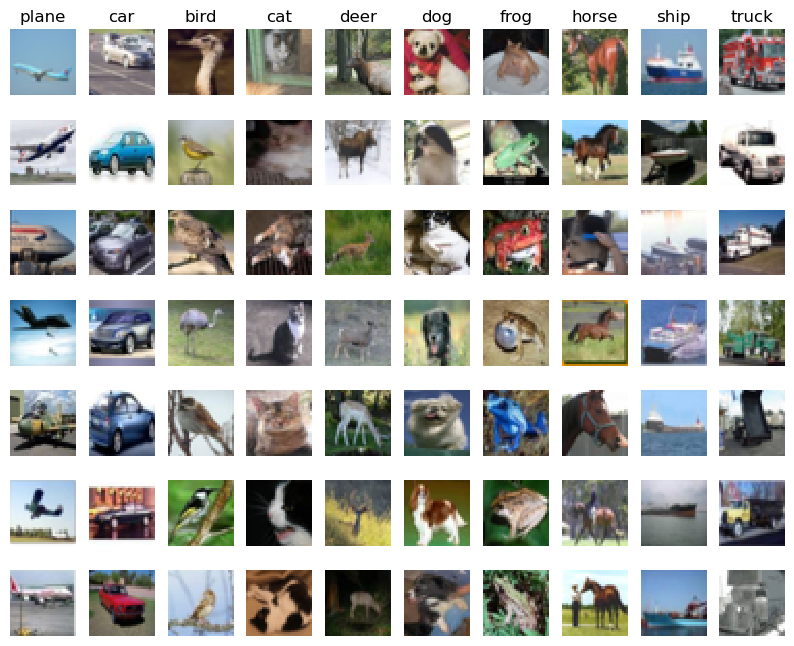

In [12]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y) # `np.flatnonzero` returns the indices of non-zero elements in the input array
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8')) # `astype('uint8')` converts the image to unsigned 8-bit integer
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

# Image data preprocessing

We will use the simplest feature engineering method: take all the pixels in each image directly and add a little data normalization.
- Each CIFAR-10 color image is already the same size of $32 \times 32$ pixels, so the first thing we need to do is stretch each of the three Red, Green, Blue channels of the image into a vector of size $3 \times 32 \times 32 = 3072$.
- Since each pixel has a value of a natural number from $0$ to $255$, we need a little data normalization. In Machine Learning, the simplest way to normalize data is to center the data, that is, to make each feature have an average of $0$. A simple way to do this is to calculate the average of all the images in the training set to get the average image, then subtract this average image from all the images. Similarly, we also use this average image to normalize the data in the validation set and test set.

## Bias trick

In general, given a coefficient matrix $\mathbf{W} \in \mathbb{R}^{d\times C}$, an input $\mathbf{x} \in \mathbb{R}^d$ and a bias vector $\mathbf{b} \in \mathbb{R}^C$, we can calculate the output of this layer as:

$$f(\mathbf{x}, \mathbf{W}, \mathbf{b}) = \mathbf{W}^T\mathbf{x} + \mathbf{b}$$

To simplify the above expression, we can add a $1$ at the end of $\mathbf{x}$ and concatenate the vector $\mathbf{b}$ into the matrix $\mathbf{W}$ as shown in *Figure 1*. Now we have only one data variable $\mathbf{W}$ instead of two data variables as before. From now on, when we write $\mathbf{W}$ and $\mathbf{x}$, we implicitly understand them as new variables and new data as shown in the right part of *Figure 1*. Next, we write a program to take data from the CIFAR10 set, normalize the data and add a $1$ feature to the end of each vector. At the same time, $1000$ data from the training set are also separated as validation sets.

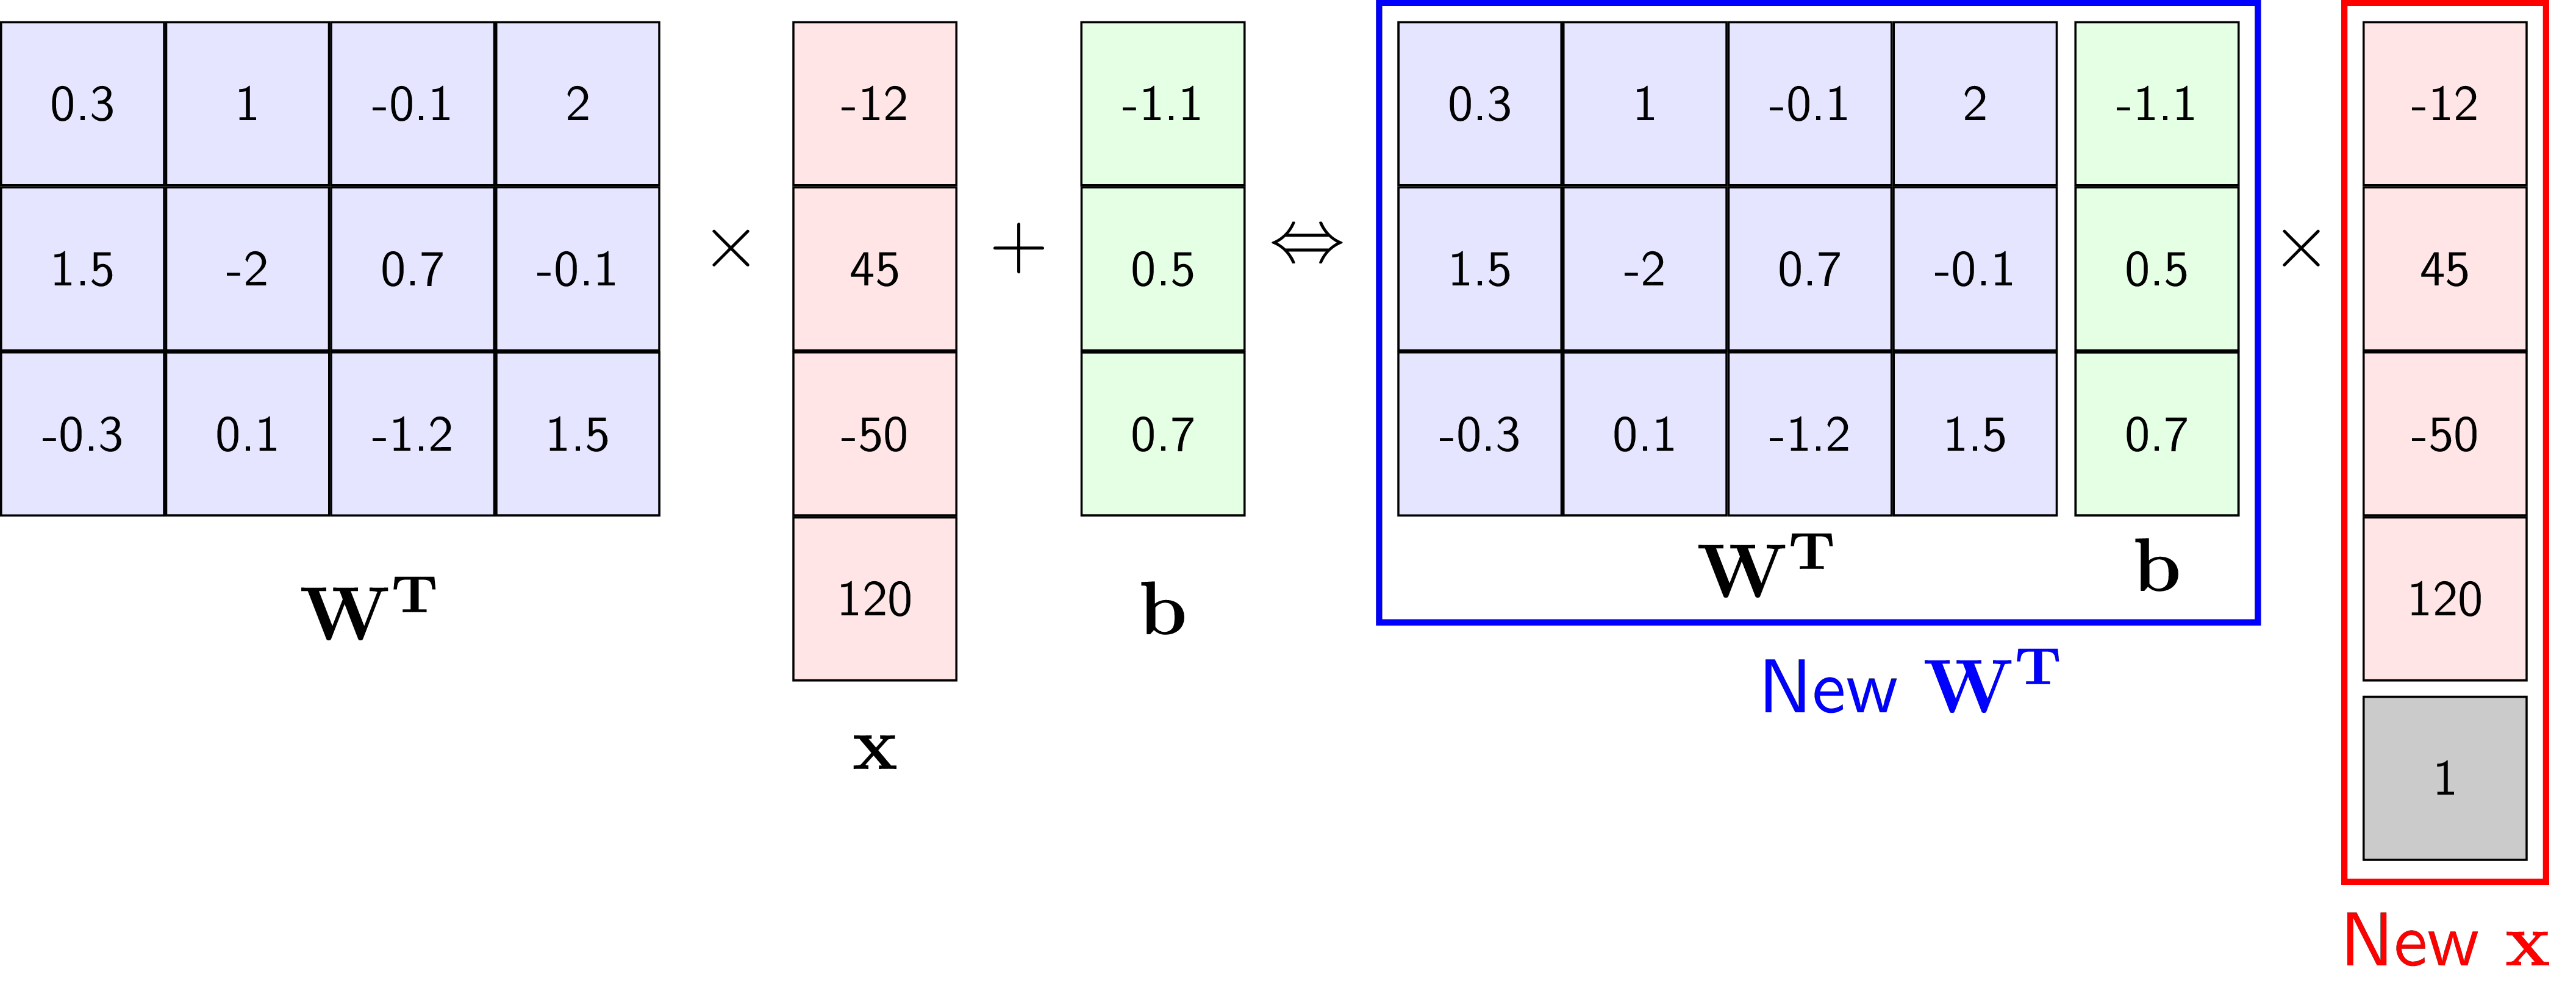

*Figure 1: Bias trick*

In [13]:
# Extract a validation from X_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= 1000)
# mean image of all training images
img_mean = np.mean(X_train, axis = 0)

In [14]:
def feature_engineering(X):
    X -= img_mean # zero-centered
    N = X.shape[0] # number of data point
    X = X.reshape(N, -1) # vectorizetion
    return np.concatenate((X, np.ones((N, 1))), axis = 1) # bias trick

In [15]:
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)
X_test = feature_engineering(X_test)
print('X_train shape = ', X_train.shape)
print('X_val shape = ', X_val.shape)
print('X_test shape = ', X_test.shape)

X_train shape =  (49000, 3073)
X_val shape =  (1000, 3073)
X_test shape =  (10000, 3073)


# Build the loss function for multi-class SVM